In [2]:
import importlib as imp
import graph_statistics
import graph_analysis

In [3]:
imp.reload(graph_statistics)
imp.reload(graph_analysis)

<module 'graph_analysis' from 'C:\\Users\\SIMONE\\Desktop\\Movielens - Big\\py\\graph_analysis.py'>

In [4]:
from graph_analysis import *
from graph_statistics import *

In [5]:
from collections import defaultdict

### Sequence of Bipartite Graphs and projected users networks (PEAR)

In [7]:
df = pd.read_csv('csv/dataframe.csv',index_col=0,dtype={'userId': int,'movieId': str,'year': int})
df.sort_index(inplace=True)
df.head()

In [9]:
G,users,movies = create_bipartite_graph(df,rating=True,rating_cutoff=0.0)

In [10]:
# Sequence by year
Gs = defaultdict(list)

tw = [365]
for i,t in enumerate(tw):
    Gs[i] = graph_seq(G,start_date=datetime.datetime(1996,1,1),tw_days=t)

In [11]:
Gs_user = user_projection_pearson_seq(Gs[0],users)

In [12]:
Gs_user_slc = slice_network_seq(Gs_user,0.147)

In [42]:
for i in range(len(Gs_user_slc)):
    nx.write_gexf(Gs_user_slc[i],'Gs_user_{}.gexf'.format(i))

### Network Measures

In [51]:
d = [nx.density(Gs_user_slc[i]) for i in range(len(Gs_user_slc))]
d = pd.Series(d,index=Gs_user_slc.index)

edges = [len(Gs_user_slc[i].edges()) for i in range(len(Gs_user_slc))]
edges = pd.Series(edges,index=Gs_user_slc.index)

nodes = [len(Gs_user_slc[i].nodes()) for i in range(len(Gs_user_slc))]
nodes = pd.Series(nodes,index=Gs_user_slc.index)


cc = [nx.average_clustering(Gs_user_slc[i]) for i in range(len(Gs_user_slc))]
cc = pd.Series(cc,index = Gs_user_slc.index)


avg_sp = [nx.average_shortest_path_length(max(nx.connected_component_subgraphs(Gs_user_slc[i]), key=len)) for i in range(len(Gs_user_slc))]
avg_sp = pd.Series(avg_sp,index = Gs_user_slc.index)



gcc = [ len(max(nx.connected_component_subgraphs(Gs_user_slc[i]),key = len)) for i in range(len(Gs_user_slc))]
gcc = pd.Series(gcc,index=Gs_user_slc.index)

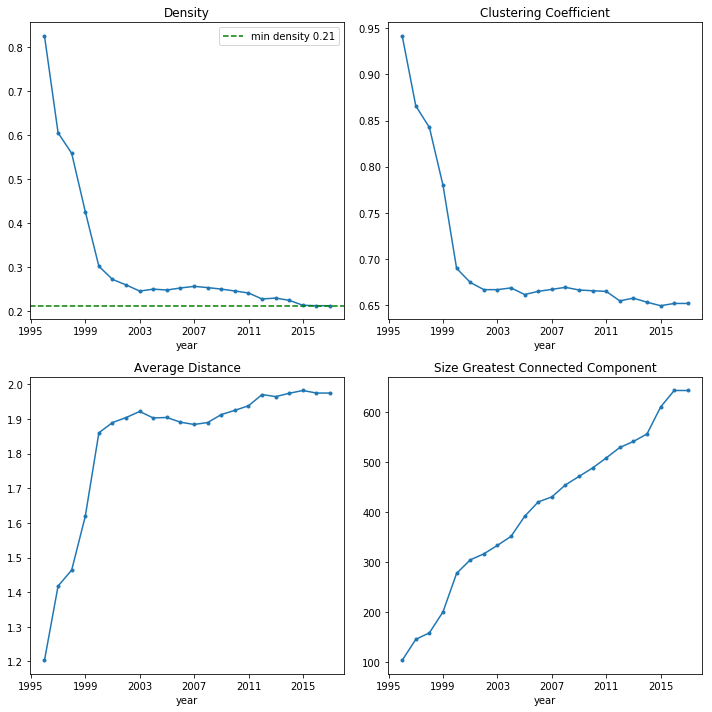

In [486]:
_,axs = plt.subplots(2,2,figsize=(10,10))

axs[0,0].plot(d,'.-')
axs[0,0].set_title('Density')
axs[0,0].set_xlabel('year')
#axs[0,0].set_yticks(np.linspace(0.04,0.3,14))
axs[0,0].axhline(min(d), color='green', linestyle='--',label = 'min density {}'.format(round(min(d),2)))
axs[0,0].legend()

axs[0,1].plot(cc,'.-')
axs[0,1].set_title('Clustering Coefficient')
axs[0,1].set_xlabel('year')

axs[1,0].plot(avg_sp,'.-')
axs[1,0].set_title('Average Distance')
axs[1,0].set_xlabel('year')

axs[1,1].plot(gcc,'.-')
axs[1,1].set_title('Size Greatest Connected Component')
axs[1,1].set_xlabel('year')
    
plt.tight_layout()
plt.show()

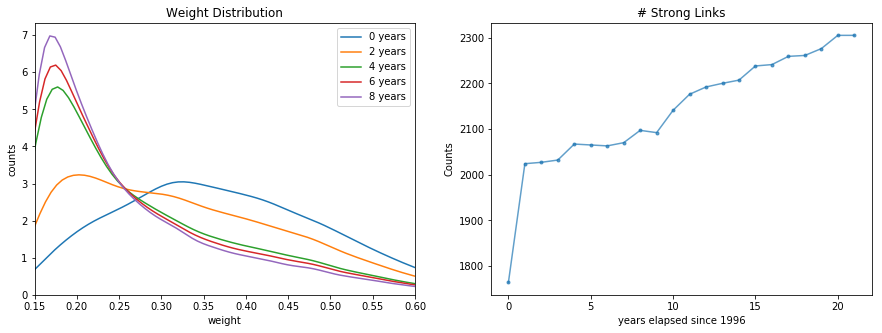

In [19]:
import seaborn as sns

seq = []
for i in range(len(Gs_user_slc)):
    seq.append([d['weight'] for u,m,d in Gs_user_slc[i].edges(data=True)])

_, ax = plt.subplots(nrows=1,ncols=2,figsize = (15,5))


for i in range(0,len(seq)-12,2):
    sns.distplot(seq[i],hist=False,label= '{} years'.format(round(i,1)),norm_hist=False,ax=ax[0])
    
ax[0].set_title('Weight Distribution')
ax[0].set_xlabel('weight')
ax[0].set_ylabel('counts')
ax[0].legend()
ax[0].set_xlim((0.15,0.6))


df_w[df_w > 0.4].count().plot(style = '.-',alpha = 0.7,ax = ax[1])

ax[1].set_title('# Strong Links')
ax[1].set_xlabel('years elapsed since 1996')
ax[1].set_ylabel('Counts')

plt.show()   

In [16]:
weg = []

for i in range(len(Gs_user_slc)):
    weg.append([d['weight'] for u,m,d in Gs_user_slc[i].edges(data=True)])

In [17]:
deg = []
for i in range(len(Gs_user_slc)):
    deg.append(list(nx.degree_centrality(Gs_user_slc[i]).values()))

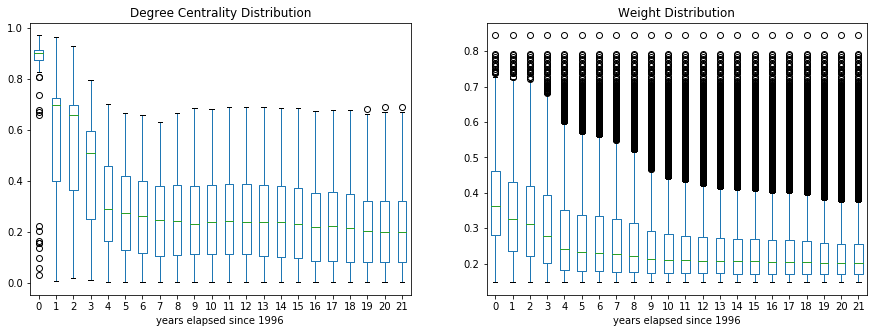

In [18]:
_, ax = plt.subplots(nrows=1,ncols=2,figsize = (15,5))

df_d = pd.DataFrame(deg).transpose()
#df_d.columns = Gs_user_slc.index.astype(str)
df_d.plot.box(ax = ax[0])

ax[0].set_title('Degree Centrality Distribution')
ax[0].set_xlabel('years elapsed since 1996')


df_w = pd.DataFrame(weg).transpose()
df_w.plot.box(ax = ax[1])

ax[1].set_title('Weight Distribution')
ax[1].set_xlabel('years elapsed since 1996') 

plt.show()

### Recommender System

In [18]:
df_movie = pd.read_csv('csv/dataframe_movie.csv',index_col=0,dtype={'movieId': str,'year': int})
df_movie.sort_index(inplace=True)
df_movie.head()

,movieId,title,genres,year
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,m2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,m3,Grumpier Old Men (1995),Comedy|Romance,1995
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,m5,Father of the Bride Part II (1995),Comedy,1995


In [20]:
import recommendation
imp.reload(recommendation)
from recommendation import *

In [21]:
alpha = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [22]:
Gs_alpha = defaultdict(list)
Gs_user_alpha = defaultdict(list)
summary_alpha = []

alpha = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for i in range(len(alpha)):
    Ns,Ns_user,summary = graph_reccomendation_col(Gs=Gs[0],Gs_user=Gs_user_slc,df_movie = df_movie,users=users,movies=movies,
                                            start_date=datetime.datetime(2000,1,1),threshold=0.147,min_new_items=10,
                                            alpha=alpha[i])    
    Gs_alpha[i] = Ns
    Gs_user_alpha[i] = Ns_user
    summary_alpha.append(summary)

In [23]:
for i in range(len(Gs_user_alpha)):
    for j in range(len(Gs_user_alpha[i])):
        nx.write_gexf(Gs_user_alpha[i][j],'graph_user_alpha{0}_{1}.gexf'.format(i,j))

In [24]:
for i in range(len(Gs_alpha)):
    for j in range(len(Gs_alpha[i])):
        nx.write_edgelist(Gs_alpha[i][j],'graph_alpha{0}_{1}.csv'.format(i,j),data=[('rating',float),('date',str)],delimiter =' ')

In [25]:
for i in range(len(summary_alpha)):
    summary_alpha[i].to_csv('summary_pear_seq{}.csv'.format(i))

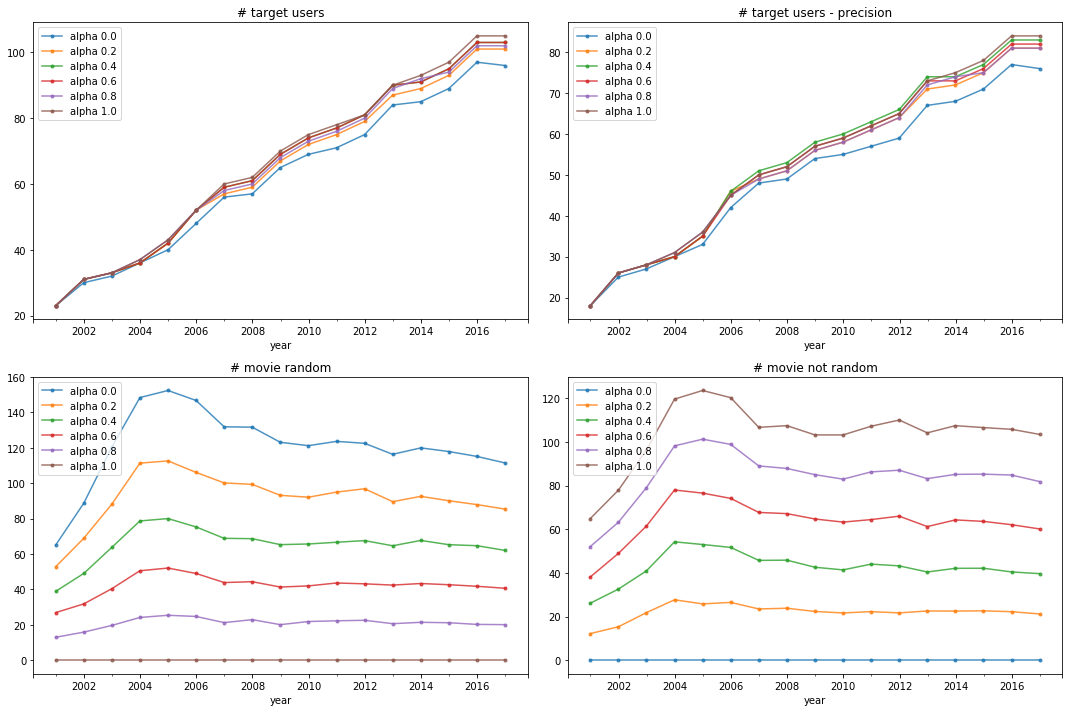

In [26]:
# The number of edges does not vary by construction
# Plot only nodes and density

_,axs = plt.subplots(2,2,figsize=(15,10))

for i in range(0,len(summary_alpha),2):
    summary_alpha[i]['users'].apply(lambda x: len(x)).plot(label = 'alpha {}'.format(alpha[i]), style = '.-',alpha = 0.8, ax = axs[0,0])

axs[0,0].legend()
axs[0,0].set_title('# target users')
axs[0,0].set_xlabel('year')

for i in range(0,len(summary_alpha),2):
    summary_alpha[i]['cov_users_prec'].plot(label = 'alpha {}'.format(alpha[i]),style = '.-',alpha = 0.8,ax = axs[0,1])

axs[0,1].legend()
axs[0,1].set_title('# target users - precision')
axs[0,1].set_xlabel('year')

for i in range(0,len(summary_alpha),2):
    summary_alpha[i]['movie_r'].plot(label = 'alpha {}'.format(alpha[i]),style = '.-',alpha = 0.8, ax = axs[1,0])

axs[1,0].legend()
axs[1,0].set_title('# movie random')
axs[1,0].set_xlabel('year')

for i in range(0,len(summary_alpha),2):
    summary_alpha[i]['movie_nr'].plot(label = 'alpha {}'.format(alpha[i]),style = '.-',alpha = 0.8,ax = axs[1,1])

axs[1,1].legend()
axs[1,1].set_title('# movie not random')
axs[1,1].set_xlabel('year')

plt.tight_layout()
plt.show()

#### Precision

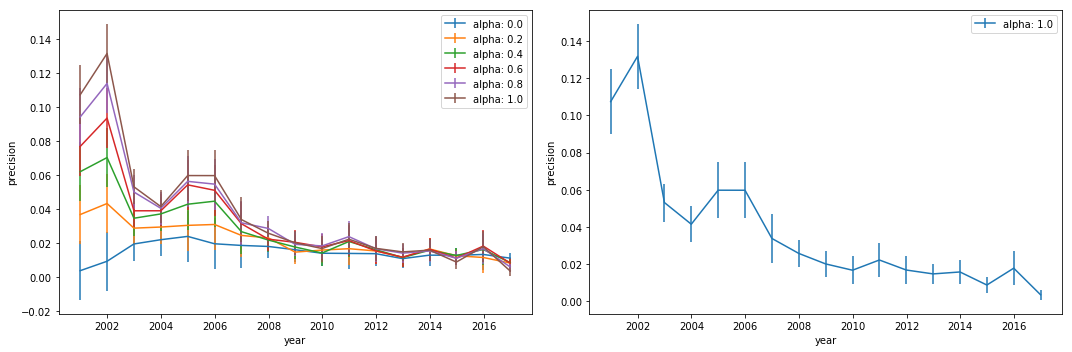

In [138]:
plt.subplots(1,2,figsize = (15,5))

plt.subplot(1,2,1)
for i in range(0,11,2):
    plt.errorbar(summary_alpha[i]['avg_prec'].index, summary_alpha[i]['avg_prec'].values, yerr= summary_alpha[10]['std_prec'].values/6,label = 'alpha: {}'.format(alpha[i]))

plt.legend(loc = 'upper right')
plt.ylabel('precision')
plt.xlabel('year')

plt.subplot(1,2,2)
plt.errorbar(summary_alpha[10]['avg_prec'].index, summary_alpha[10]['avg_prec'].values, yerr= summary_alpha[10]['std_prec'].values/6,label = 'alpha: 1.0')

plt.legend()
plt.ylabel('precision')
plt.xlabel('year')


plt.tight_layout()
plt.show()

## RS - User Graph Sequence

This sequence reflects the evolution of implicit users relationships guided by the action of the previous recommendation engine. As done earlier, the following plots describe how global network measures and the weight distribution change over time.

In [28]:
d_RS = []
edges_RS = []
nodes_RS = []
cc_RS = []
avg_RS =[]
gcc_RS = []

for j in range(len(Gs_user_alpha)):
    d_RS.append(pd.Series([nx.density(Gs_user_alpha[j][i]) for i in range(len(Gs_user_alpha[j]))],index = Gs_user_alpha[j].index))
        
for j in range(len(Gs_user_alpha)):
    cc_RS.append(pd.Series([nx.average_clustering(Gs_user_alpha[j][i]) for i in range(len(Gs_user_alpha[j]))],
                              index = Gs_user_alpha[j].index))
    
for j in range(len(Gs_user_alpha)):
    avg_RS.append(pd.Series([nx.average_shortest_path_length(max(nx.connected_component_subgraphs(Gs_user_alpha[j][i]), key=len)) for i in range(len(Gs_user_alpha[j]))],
                        index = Gs_user_alpha[j].index))

    
for j in range(len(Gs_user_alpha)):
    gcc_RS.append(pd.Series([len(max(nx.connected_component_subgraphs(Gs_user_alpha[j][i]),key = len)) for i in range(len(Gs_user_alpha[j]))],
                        index = Gs_user_alpha[j].index))

In [29]:
f = open("gcc_RS.pkl","wb")
pickle.dump(gcc_RS,f)
f.close()

f = open("d_RS.pkl","wb")
pickle.dump(d_RS,f)
f.close()

f = open("avg_RS.pkl","wb")
pickle.dump(avg_RS,f)
f.close()

f = open("edges_RS.pkl","wb")
pickle.dump(edges_RS,f)
f.close()

f = open("nodes_RS.pkl","wb")
pickle.dump(nodes_RS,f)
f.close()

f = open("cc_RS.pkl","wb")
pickle.dump(cc_RS,f)
f.close()

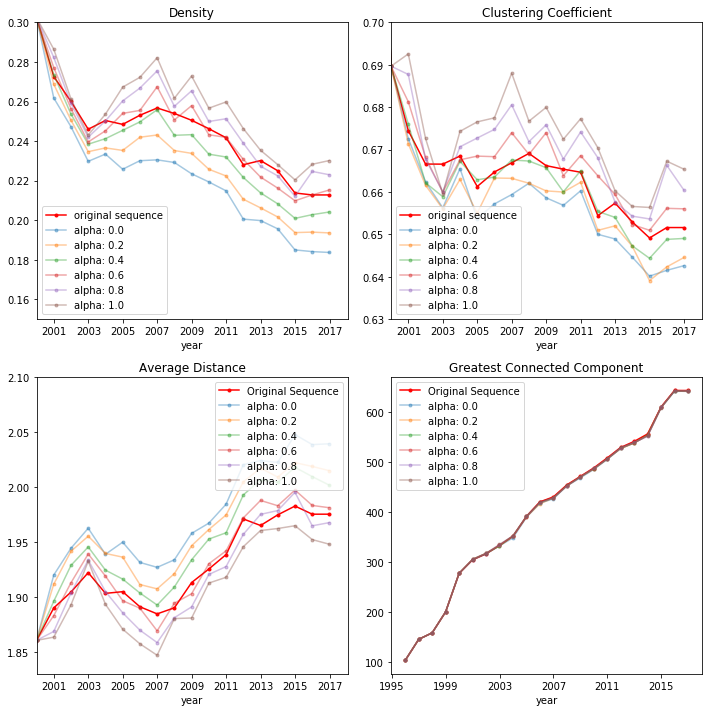

In [52]:
# The number of edges does not vary by construction
# Plot only nodes and density

_,axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].plot(d,'r.-',alpha = 1,label = 'original sequence')

for i in range(0,len(d_RS),2):
    axs[0,0].plot(d_RS[i],'.-',label = 'alpha: {}'.format(alpha[i]),alpha = 0.4)

axs[0,0].legend()
axs[0,0].set_title('Density')
axs[0,0].set_xlabel('year')
axs[0,0].set_xlim(('2000-01-01',None))
axs[0,0].set_ylim((0.15,0.3))


axs[0,1].plot(cc,'r.-',alpha= 1,label = 'original sequence')

for i in range(0,len(cc_RS),2):
    axs[0,1].plot(cc_RS[i],'.-',label = 'alpha: {}'.format(alpha[i]),alpha = 0.4)

axs[0,1].legend()
axs[0,1].set_title('Clustering Coefficient')
axs[0,1].set_xlabel('year')
axs[0,1].set_xlim(('2000-01-01',None))
axs[0,1].set_ylim((0.63,0.7))
axs[0,1].legend(loc = 'lower left')



axs[1,0].plot(avg_sp,'r.-',alpha= 1,label = 'Original Sequence')

for i in range(0,len(avg_RS),2):
    axs[1,0].plot(avg_RS[i],'.-',label = 'alpha: {}'.format(alpha[i]),alpha = 0.4)


axs[1,0].legend(loc = 'upper right')
axs[1,0].set_title('Average Distance')
axs[1,0].set_xlabel('year')
axs[1,0].set_xlim(('2000-01-01',None))
axs[1,0].set_ylim((1.83,2.10))


axs[1,1].plot(gcc,'r.-',alpha= 1,label = 'Original Sequence')

for i in range(0,len(gcc_RS),2):
    axs[1,1].plot(gcc_RS[i],'.-',label = 'alpha: {}'.format(alpha[i]),alpha = 0.4)


axs[1,1].legend()
axs[1,1].set_title('Greatest Connected Component')
axs[1,1].set_xlabel('year')


plt.tight_layout()
plt.show()

In [31]:
seq = []

for j in range(len(alpha)):
    seq.append([d['weight'] for u,m,d in Gs_user_alpha[j][-1].edges(data=True) if d['weight'] > 0.4])

seq.append([d['weight'] for u,m,d in Gs_user_slc[-1].edges(data=True) if d['weight'] > 0.4])   

In [32]:
pd_strw = pd.DataFrame(seq).transpose().sum()
pd_strw.index = np.append(alpha,'Source')

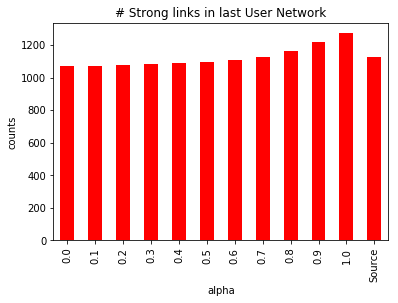

In [139]:
pd_strw.plot.bar(color = 'r',alpha = 1)


plt.title('# Strong links in last User Network')
plt.ylabel('counts')
plt.xlabel('alpha')
plt.show()

### Focal Closure

In [ ]:
foc = focal_closure(Gs=Gs[0],Gs_user_sliced=Gs_user_slc,start_date=datetime.datetime(2000,1,1),window=2,max_k=10)

In [ ]:
foc.to_csv('focal_source.csv')

In [93]:
foc_rs = []

for i in range(10):
    foc_rs.append(pd.read_csv('focal/focal_synthetic{}.csv'.format(i),index_col=0))

In [ ]:
for i in range(len(foc_rs)):
    foc_rs[i].to_csv('focal_synthetic{}.csv'.format(i))

In [87]:
# Compare next plot with baseline 1 - (1-p)^k
# Find p as the slope of a linear fit 

lm_foc = lin_reg(x=np.arange(10),y=foc.mean(axis=1).values[:10])
p_foc = lm_foc.slope

baseline_foc = np.array([(1 - np.power((1-p_foc),k))  for k in range(10)])
baseline_shift_foc = np.array([(1 - np.power((1-p_foc),k-1))  for k in range(10)])

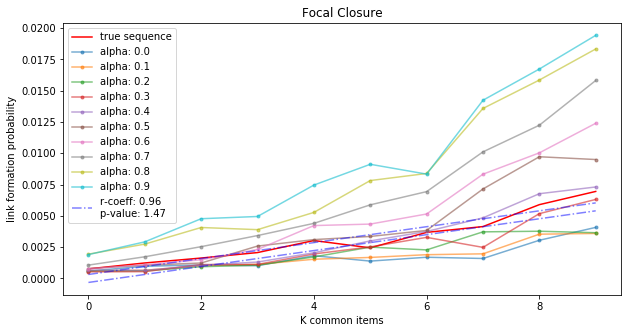

In [117]:
plt.figure(figsize = (10,5))

foc.mean(axis=1).plot(style = 'r-',label = 'true sequence',alpha=1)

for i in range(0,len(foc_rs)):
    foc_rs[i].mean(axis=1).plot(style = '.-',label = 'alpha: {}'.format(round(alpha[i],2)),alpha = 0.6)

plt.plot(lm_foc.intercept + baseline_foc,'b-.',alpha = 0.5, label = 'r-coeff: {0}\np-value: {1}'.format(round(lm_foc.rvalue,2),1.47))
plt.plot(lm_foc.intercept + baseline_shift_foc,'b-.',alpha = 0.5)

plt.title('Focal Closure')
plt.xlabel('K common items')
plt.ylabel('link formation probability')
plt.legend(loc = 'upper left')
plt.show()